In [1]:
import re
a = 'a0*a1*a0^-1*a1^-3*a2^11'

# Una punietera funcion que dada una trenza de la forma a1^2*a2^-20*a15^21, 
# returns the list associated to that braid (in this case, list would be [0,0,-1,-1,-1...]
# so that string '=' b(list)) where b is the braid group of n strands 
# (si estas en B3 y me pasas un a15 NOT MY FAULT)
# letter indicates the letter with which you instantiated the braid group (i.e., b ) BraidGroup(n, letter)
# Me cago en la leche wue ya podrian darme esto hecho, AQUI YO COMO UNA GILIPOLLAS QUITANDOME TIEMPO DE 
# PRACTICAS PARA PARSEAR TRENZAS. CACA.
def str_to_list(string, letter = 'a'):
    string = string.replace(letter, '')
    # a0/a1 == braid([a0, -a1])
    string = string.replace('/', '*-')
    # a0^-1 == braid([-a0])
    # places contains thr position of each ^, and 
    places = [m.start() for m in re.finditer('\^[-]?[0-9]+', string)]
    # now, powers contains the number associated to each ^ pointed by places
    powers = [the_power(place, string) for place in places]
    # repes is a list of the strings that shall replace the '^n' inside the input string
    # for example, if '2^3' in string, there will be an element in repes of the form '*2*2*2'
    # similarly, if '3^-3' in string, there will be an element in repes of the form '*-3*-3*-3'
    repes = [repe(string, place, power) for (place, power) in zip(places, powers)]
    # now, we should 'erase' every gen^n from the string and replace it with the correct
    # element from repes (*gen*gen*gen...). First we separate the initial string
    splitted = re.split('[0-9]+\^[-]?[0-9]+', string)
    # Then we introduce the 'repes' between the separations
    without_powers = ''
    for (splt, rep) in zip(splitted, repes):
        without_powers = without_powers + splt + rep
    without_powers += splitted[-1]
    # YYYYY PORFIN, the only thing left to do is to take away the * and to sum one up to each number
    # Por alguna extrania razon que no alcanzo a comprender, a0*a3 = [1,4] --> sin sentidos de la vida de python
    braid_list = [plus_one(elem) for elem in without_powers.split('*')]
    return braid_list

#############################################################
##### FUNCIONES AUXILIARES PA LA JAMADA DE AHI ARRIBA #######
#############################################################

# Given a string and if ini points to a '^', the power returns the number that comes after '^'
def the_power(ini,string):
    #end contains the index of the first * after the ^. That is, the end of the number after the ^
    end = string.find('*', ini)
    if end != -1:
        return int(string[ini+1:end])
    # if end = -1, no '*' was found after '^' --> the number is at the end of the string
    return int(string[ini+1:])

# string is of the form 0^13*1^-2*3...(coming from a0^13*a1^-2...)
# ini points to the ^ and power is an integer describing the number
# just after ^
def repe(string, ini, power):
    if power > 0:
        operator = '*'
    else:
        operator = '*-'
    # The generator is the number just before the '^', (a0^3)
    gen = string[ini-1]
    
    # ret will be '*gen*gen*gen...' as many times as power indicates
    ret = ''
    for i in range(abs(power)):
        ret = ret + operator + gen
    # We take away the initial '*' porq si no se lia :D (Que feo :/)
    return ret[1:]

# elem is a string, either 'i' or '-i', i > 0
# returns integer i+1 in the first case, -i-1 in the second one
def plus_one(elem):
    # special case of elem = '-0' should return -1, not 1
    if str(elem) == '-0':
        return -1
    elif int(elem) >= 0: 
        
        return int(elem) + 1
    return int(elem) - 1



In [2]:
########### Y OTRAS COSIS PARA LA CRIPTO ############
# returns b1 * b2 * b1^-1, where b1, b2 are braid objects
def conjugate(b1, b2):
    return b1*b2/b1

# Go to  Anshel-Anshel-Goldfeld y te enteras mejor
# If alice_or_bob == 'alice' 
# Conjugates the inverse of your own private key by the other (Bob's) private key, given a list 
# with the conjugates of the generators of the shared public subgroup by Bob's private key. 
# If alice_or_bob == 'bob':
# Conjugates your own private key by the other (Alice's) private key
# Creo que debo estar haciendo un destrozo a la lengua inglesa y a su teoria de grupos. Pero es lo que hay.
#
# private is a private key like 'a0*a1^3*a4^-2...' A STRING. Let's say its Alice's private key
# conj_gens is a list like ['a0*a1', 'a1^3*a^-2', 'a4/a5', ...], where each element is a string with 
# the result of conjugating gen by b, where b is Bob's private key and gen is an element generating
# the public subgroup shared by Alice and Bob
# Returns a braid (not a string, not a list)
def conjugate_private(private, conj_gens, group, alice_or_bob, letter = 'a'):
    result = group([])
    # make list from conj_gens and from private, so that we can work with them easily
    l_conj_gens = [str_to_list(conj_gen, letter) for conj_gen in conj_gens]
    if alice_or_bob == 'alice':
        # To get the list associated with alice's inverse key, we get the list associated with
        # alice's key, reverse it and multiply it *-1
        l_private = [-1*elem for elem in str_to_list(str(private), letter)[::-1]]
    elif alice_or_bob == 'bob':
        l_private = str_to_list(str(private), letter)
    # Now, each b_priv * gen_i / b_priv is contained in the (i-1)th element of conj_gens
    # Yo no se explicar de manera facil y corta lo q voy a hacer ahora. Pero voy a conjugar
    # la clave privada propia por la clave privada ajena y punto.
    for element in l_private:
        conj_gen = group(l_conj_gens[abs(element) - 1])
        if element > 0:
            result *= conj_gen
        
        else:
            result *= conj_gen^-1
    return result

# Es un poco pesado andar pasando como argumentos strings en vez de trenzas, pero tiene sentido si piensas 
# que son un mail que te ha llegado desde la otra punta del planeta (el mundo todavia no esta preparado
# para enviar trenzas por mail, hasta entonces, seguiremos enviando strings)

# own_private: string of a braid in Bn (for example. 'a1*a4^-2*a7) which is your private key
# conj_gens: list where each element is a string with the result of conjugating gen by b, where b is the other 
# person's private key and gen is a generator of the public subgroup shared by Alice and Bob
# alice_or_bob = 'alice' if you are alice, 'bob' if you are bob. See below.
#
# Given you own private key (lets say its a) and the public shared subgroup generators conjugated by
# the other person's private key (lets say b), returns the private shared key a*b/a/b
# If you are giving the 'a' key in the own_private argument, alice_or_bob should be the string 'alice'
# If you are giving the 'b' key in the own_private argument, alice_or_bob should be the string 'bob'
def private_shared_key(own_private, conj_gens, alice_or_bob, group, letter = 'a'):
    factor = conjugate_private(own_private, conj_gens, group, alice_or_bob, letter = 'a')
    if alice_or_bob == 'alice':
        return group(str_to_list(own_private)) * factor
    elif alice_or_bob == 'bob':
        return factor * group(str_to_list(own_private))^-1

b = BraidGroup(7, 'a')
subgroup.<a0,a1,a2> = BraidGroup(4)

a_private = subgroup([1,2,-1,3])
b_private = subgroup([3,2,-1,-2])

a_to_b = [conjugate(a_private, gen) for gen in subgroup.gens()]
b_to_a = [conjugate(b_private, gen) for gen in subgroup.gens()]


conjugate_private(str(a_private), [str(conj_gen) for conj_gen in b_to_a], subgroup, 'alice', letter = 'a')



a2*a1*a0^-1*a1^-1*a2^-1*a0*a1^-1*a0^-1*a1*a0*a1^-1*a2^-1

In [65]:
br = []
b = BraidGroup(3, 'a')
br.append(b([1,-1]))
br.append(b([1]))
br.append(b([2]))
br.append(b([1,2]))
br.append(b([1,1,1,1,1,1,1,1]))
b = BraidGroup(6, 'a')
br.append(b([3,5,-3,-4,2,-1,-2]))

i = 0
for im in br:
    c = im.plot(aspect_ratio = 5, thickness=3)
    c.save(str(i) + '.png')
    i += 1


In [69]:
br = []
b = BraidGroup(5, 'a')
br.append(b([1]))
br.append(b([2]))
br.append(b([3]))
br.append(b([4]))
i = 0
for im in br:
    c = im.plot(aspect_ratio = 5, thickness=3)
    c.save('a' + str(i) + '.png')
    i += 1


In [254]:
print private_shared_key(str(a_private), [str(conj_gen) for conj_gen in b_to_a], 'alice', subgroup).left_normal_form()
print private_shared_key(str(b_private), [str(conj_gen) for conj_gen in a_to_b], 'bob', subgroup).left_normal_form()


((a0^-1*a1^-1*a2^-1*a0^-1*a1^-1*a0^-1)^3, a0*a1*a2*a1*a0, a0*a1*a2, a2*a1, a1, a1, a1*a0*a2, a2*a1*a0)
((a0^-1*a1^-1*a2^-1*a0^-1*a1^-1*a0^-1)^3, a0*a1*a2*a1*a0, a0*a1*a2, a2*a1, a1, a1, a1*a0*a2, a2*a1*a0)


In [58]:
sage.plot.colors.rainbow(4, format='hex')

['#ff0000', '#7fff00', '#00ffff', '#7f00ff']

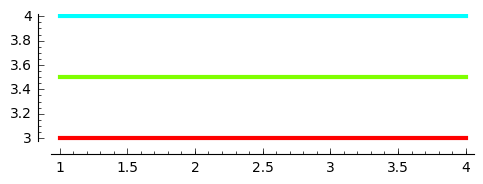

In [62]:
G = Graphics()
G += plot(3,(x, 1, 4), color='#ff0000', thickness=3, aspect_ratio = 0.9)
G += plot(3.5, (x, 1, 4),color='#7fff00', thickness=3)
G += plot(4, (x, 1, 4),color='#00ffff', thickness=3)
G.show(figsize=[5,5] )
G.save('id.png')

In [26]:
a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a1*a0*a1^-1*a2^-1*a2*a1*a0^-1*a1^-1*a2*a1*a0*a1^-1*a2^-1

a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a2*a1*a0*a1^-1*a2^-1

In [7]:
# alice has b_priv * gen / b_priv
# now, Alice can compute b_priv / a_priv / bpriv without knowing b_priv!
a_str = str(a_private)

In [209]:
a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a2*a1*a0*a1^-1*a2^-1, a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a2*a1*a0*a1^-1*a2^-1

(a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a2*a1*a0*a1^-1*a2^-1,
 a2*a1*a0^-1*a1^-1*a0*a1*a0^-1*a2*a1*a0*a1^-1*a2^-1)

In [121]:
without = str_to_list(a)
print without
print b(without)

[1, 2, -1, -2, -2, -2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
a0*a1*a0^-1*a1^-3*a2^11
